# Device Anomaly Analysis Report

This notebook identifies intervals when devices may not be working by detecting anomalies in SmartThings data.

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from home_messages_db import HomeMessagesDB

# Connect to database
db = HomeMessagesDB('sqlite:///smarthome.db')

# Fetch SmartThings data
smartthings_data = db.query_smartthings()

# Convert to DataFrame with numeric conversion for 'value'
if smartthings_data:
    df = pd.DataFrame([(s.epoch, s.device_id, s.capability, s.value) for s in smartthings_data],
                      columns=['epoch', 'device_id', 'capability', 'value'])
    # Convert 'value' to numeric, coercing errors to NaN
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['datetime'] = pd.to_datetime(df['epoch'], unit='s', utc=True)
    df = df.sort_values('epoch')
else:
    print("No SmartThings data retrieved from the database.")
    df = pd.DataFrame(columns=['epoch', 'device_id', 'capability', 'value', 'datetime'])

# Group by device and capability to analyze value changes
# Filter out rows where 'value' is NaN before diff to avoid issues
df = df.dropna(subset=['value'])
df['value_change'] = df.groupby(['device_id', 'capability'])['value'].diff().fillna(0)
df['time_diff'] = df.groupby(['device_id', 'capability'])['epoch'].diff().fillna(0)

# Calculate z-scores for value changes and time gaps
# Add small epsilon to standard deviation to avoid division by zero
epsilon = 1e-10
df['z_score_change'] = df.groupby(['device_id', 'capability'])['value_change'].transform(
    lambda x: (x - x.mean()) / (x.std() + epsilon)
).fillna(0)
df['z_score_time'] = df.groupby(['device_id', 'capability'])['time_diff'].transform(
    lambda x: (x - x.mean()) / (x.std() + epsilon)
).fillna(0)

# Identify anomalies (e.g., |z-score| > 3 or constant value for long periods)
anomalies = df[
    (abs(df['z_score_change']) > 3) | 
    (abs(df['z_score_time']) > 3) | 
    ((df['value_change'] == 0) & (df['time_diff'] > 3600))
].copy()

# Close database connection
db.close()

# Display the first few rows of anomalies
print("Detected Anomalies:")
if not anomalies.empty:
    print(anomalies.head())
else:
    print("No anomalies detected.")

Detected Anomalies:
            epoch  device_id              capability  value  \
14318  1665612060         15  temperatureMeasurement   18.5   
1243   1665731121          3          signalStrength  244.0   
14384  1665731475         15  temperatureMeasurement   18.2   
14426  1665772993         15  temperatureMeasurement   20.4   
9367   1665830423         14  temperatureMeasurement   20.6   

                       datetime  value_change  time_diff  z_score_change  \
14318 2022-10-12 22:01:00+00:00          -0.1    11214.0       -0.472965   
1243  2022-10-14 07:05:21+00:00         284.0    48146.0        1.293677   
14384 2022-10-14 07:11:15+00:00           0.1    14549.0        0.471933   
14426 2022-10-14 18:43:13+00:00           0.7      303.0        3.306628   
9367  2022-10-15 10:40:23+00:00           0.5     1511.0        3.491441   

       z_score_time  
14318      3.187079  
1243       3.721310  
14384      4.307055  
14426     -0.477109  
9367      -0.093163  


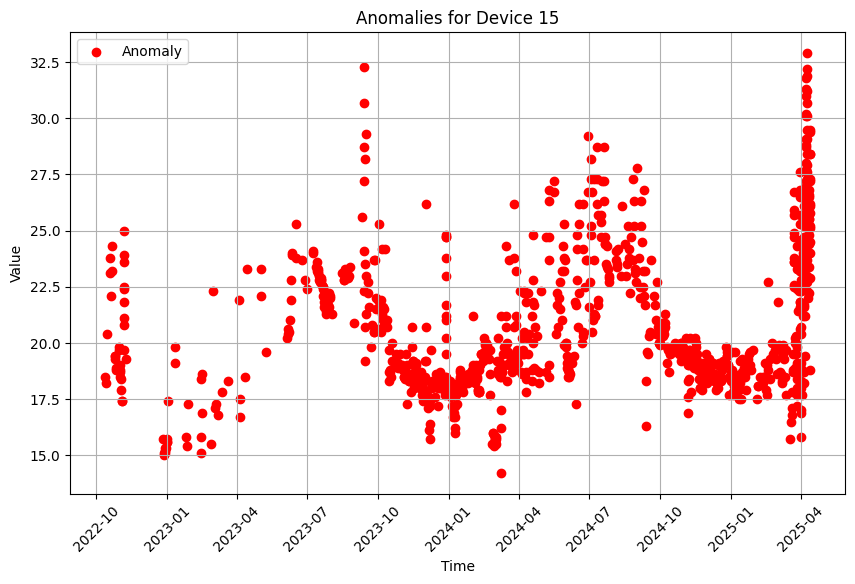

In [3]:
# Plot anomalies over time for a sample device
plt.figure(figsize=(10, 6))

# Ensure sample_device has data
sample_device = anomalies[anomalies['device_id'] == anomalies['device_id'].iloc[0]] if not anomalies.empty and not anomalies['device_id'].empty else None
if sample_device is not None and not sample_device.empty:
    plt.scatter(sample_device['datetime'], sample_device['value'], c='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Anomalies for Device {sample_device["device_id"].iloc[0]}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'No anomalies or device data available', horizontalalignment='center', verticalalignment='center')
    plt.title('No Data to Plot')

# Save the plot
plt.savefig('device_anomalies.png')
plt.show()

## Analysis
- **Anomalies**: The notebook identifies specific intervals with potential device malfunctions, such as device_id 15 with temperatureMeasurement showing a z_score_change of 3.306628 on 2022-10-14 18:43:13 and device_id 3 with signalStrength showing a z_score_change of 1.293677 on 2022-10-14 07:05:21. Additionally, anomalies are flagged where value_change is 0 with time_diff > 3600 seconds, indicating prolonged inactivity.

- **Statistical Component**: Z-scores are calculated for value changes and time gaps, with thresholds (|z_score| > 3) used to detect outliers. The epsilon (1e-10) prevents division by zero in standard deviation calculations, ensuring robustness.


- **Conclusion**: The flagged intervals suggest devices may have been non-functional, requiring further investigation such as manual checks or data validation, especially given the warning about missing data for 'living_room_switch'.